# Leah Fulmer + Kathryn Neugent - Exoplanets Winter 2019 - Homework 3

## Part 1: Rebound Installed

## Part 2: Determine when orbits become unstable

In [2]:
# Import
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import rebound

%matplotlib inline

## GJ 876 Planetary System

<img src='GJ876Rivera.png'>

In [3]:
# Initialize simulation
sim = rebound.Simulation()

# Set units
sim.units = ('days', 'AU', 'Mjupiter')

# Initial values: [d,c,b,e]
massStar = 387.76
mass = [0.02149,0.7142,2.2756,0.04594]
a = [0.0208,0.12950,0.208317,0.3343]
ecc = [0.207,0.2559,0.0324,0.055]
period = [1.937780,30.0881,61.1166,124.26]
MA = [6.2,5.14,5.68,5.85] # radians
K = [214,88.34,6.56,3.42]
o = [4.08,0.85,0.88,4.17]

# Add central star
sim.add(m = massStar)

# Add planets: [d,c,b,e]
for i in np.arange(0,len(mass)):
    sim.add(m=mass[i],a=a[i],e=ecc[i],M=MA[i],omega=o[i])

In [4]:
# Define a function to calculate K given certain inputs
def calcK(Mstar,Mp,i,P,e):
    
    # Gravitational constant in Nm^2/kg^2
    G = 6.674E-11
    
    # Mass of Jupiter [kg]
    Mj = 1.89813E27
    
    # Dumber of seconds in a day
    DtS = 86400
    
    a = (2*np.pi*G)/((Mstar+Mp)*(Mj))**2.
    b = (((Mp*Mj)**3.)*(np.sin(i)**3.))/((P*DtS)*(1-e**2.)**(3/2.))
    Kfunc = (a*b)**(1/3.)
    
    return Kfunc

In [5]:
# Create a function that solves for the mass of the planet given a K value
def findMp(K,Mstar,i,period,e,Mcurr):
    
    # Can use this approximation if Mp <<<< Mstar                 
    Mp = (Mcurr*np.sin(1.02974))/np.sin(i)
    
    # If Mp < Mstar                                               
    if (Mp > 0.01*Mstar):
        
        # Iterate 10% around the current Mp                       
        MpArr = np.arange(Mp*0.9,Mp*1.1,100)
        
        for j in np.arange(0,len(MpArr)):
            
            Knew = calcK(Mstar,MpArr[j],i,period,e)
            if (np.round(K,2)) == (np.round(Knew)):
                Mp = MpArr[j]
                
    return Mp

In [6]:
# Compare Hill radius values [AU]
# Function for calculating distance

def distCalc(x1,x2,y1,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [7]:
def main():
    
    # Stable inclination is 59 degrees = 1.02974 radians
    incInit = 1.02974

    # Iterate to zero because it will be the least stable at 0
    for inc in np.linspace(incInit, 0, 100):
        
        # For each inclination, resolve for masses
        for j in range(0,len(mass)):
            Mnew = findMp(K[j],massStar,inc,period[j],ecc[j],mass[j])
            sim.particles[j+1].m = Mnew
    
        # Iterate through 1000x
        for k in range(0,1000):
            sim.integrate(k)
            sim.move_to_com()
        
            # Determine semi-major axes
            newA = np.zeros(len(mass))
            for j in range(0,len(mass)):
                newA[j]=sim.particles[j+1].a
        
            # Determine if there have been any planetary orbit-switching
            if np.array_equal(np.argsort(newA),[0,1,2,3]) == False:
                print("Unbound at inclination:")
                print("radians ",np.round(inc,2))
                print("degrees ",np.round(inc*(180.)/np.pi,2))
                print("Orbits have switched.")
                
                # Break out of the main statement if there has been a switch
                return
    
            # Calculate distance between all of the points
            for j in range(0,len(mass)-1):
                x1 = sim.particles[j+1].x
                y1 = sim.particles[j+1].y
                
                for k in range(j+1,len(mass)):
                    x2 = sim.particles[k+1].x
                    y2 = sim.particles[k+1].y
                    dist = float(distCalc(x1,x2,y1,y2))
                    
                    # See if that distance is less than the hill radii of either planet
                    if dist < sim.particles[j+1].rhill:
                        print("Unbound at inclination:")
                        print(inc)
                        print("within hill radius")
                        return
                    if dist < sim.particles[k+1].rhill:
                        print("Unbound at inclination:")
                        print(inc)
                        print("within hill radius")
                        break

In [8]:
# Run the main method
if __name__ == "__main__": main()

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/rebound/simulation.py:531: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


Unbound at inclination:
radians  0.17
degrees  9.54
Orbits have switched.


Based on the output above, we found that the system becomes unstable at 9.54 degrees.

This translates into upper limits for the masses of the planets of:

$M_p = \frac{M_{\rm{curr}} \ *\ \sin(1.02974)}{\sin(0.17)}$

Starting Masses [M$_{Jup}$]:

[d, c, b, e] = 0.02149, 0.7142, 2.2756, 0.04594

Final Upper-Limit Masses [M$_{Jup}$]:

[d, c, b, e] = 0.11, 3.60, 11.48, 0.23

Inclination planets would be seen to transit:

$b = a\frac{\cos(i)}{R_*}\frac{1-e^2}{1+e\sin(\omega)}$

Set $b = 1$ and solve for i:

$R_*$ = 250,500,000 m = 0.001674 AU (Wikipedia)

In [12]:
# Initialize array
inc = np.zeros(len(mass))

# Write a function that calculates the inclination given a, e, and omega
def findInc(a,e,o):
    i = np.degrees(np.arccos(0.001674 / a * (1 + e * np.sin(o)) / (1 - e**2)))
    return i

# Print the inclination of each planet
for j in range(0,len(mass)):
    inc[j] = findInc(sim.particles[j+1].a,sim.particles[j+1].e,sim.particles[j+1].omega)
    print("Planet: ", j+1, "Inclination: ", inc[j])

Planet:  1 Inclination:  85.86025714368954
Planet:  2 Inclination:  89.79301028393031
Planet:  3 Inclination:  89.268090623402
Planet:  4 Inclination:  89.73154811864968


Lowest Limit is 85.86$^\circ$ (1.50 radians), therefore planet masses [M$_{Jup}$]:

[d, c, b, e] = 0.018, 0.61, 1.96, 0.04

## Part 3: Radial Velocities

In [13]:
# Small functions
def in_radians(angle_in_degrees):
    return angle_in_degrees * np.pi / 180

def in_AU_days(velocity_in_m_s):
    return velocity_in_m_s * 6.68459e-12 * 86400

def calculate_new_mass(old_mass, inclination):
    return old_mass * np.sin(59*np.pi/180)/np.sin(inclination*np.pi/180)

def in_years(days):
    return days * 1. / 365.25

In [14]:
# Write a function that runs rebound given a system inclination and outputs teh stellar radial velocity
def run_rebound(system_inclination, times):
    # Initialize
    sim = rebound.Simulation()

    # Units, system parameters, simulation parameters
    sim.units = ('yr', 'AU', 'Mjupiter')
    
    # Planets
    sim.add(m = 387.76)                                        # a
    sim.add(m = 0.02149, a = 0.020807, e = 0.207, inc = system_inclination, \
            omega = in_radians(234), M = in_radians(355))      # d
    sim.add(m = 0.7175, a = 0.129590, e = 0.2549, inc = system_inclination, \
            omega = in_radians(48.76), M = in_radians(294.59)) # c
    sim.add(m = 2.2743, a = 0.208301, e = 0.0292, inc = system_inclination, \
            omega = in_radians(50.3), M = in_radians(325.7))   # b
    sim.add(m = 0.04594, a = 0.3343, e = 0.055, inc = system_inclination, \
            omega = in_radians(239), M = in_radians(335))      # e

    # Arrays
    vrad_observed = np.zeros(n)

    # Integrate
    sim.integrator = "whfast"
    sim.dt = 1e-5
    sim.move_to_com()
    particles = sim.particles
    time = times[-1]

    sim.integrate(time, exact_finish_time = 0)

    return sim

In [15]:
# Setting up functions to compute M, E, and f for radial velocity model

def compute_M(P, tp, times):
    t0 = times[0]
    return (2 * np.pi / P) * (times - tp)

def compute_E(M, e):
    n_iterations = 0
    
    def g(E, e, M):
        return E - e * np.sin(E) - M

    def dg_dE(E, e):
        return 1 - e * np.cos(E)
    
    E = M + 0.85 * e * np.sign(np.sin(M))

    converged = False

    while (not converged) and (n_iterations < 100):
        update_E = - g(E, e, M) / dg_dE(E, e)
        E = E + update_E

        converged = np.all(np.abs(update_E) < 1e-9)
        n_iterations += 1
        
    return E

def compute_f(e, E):
    return 2 * np.arctan(((1 + e)/(1 - e))**(2) * np.tan(E / 2))

In [16]:
# Write a function that models the planetary system given the initial parameters above and 
# returns the modeled stellar radial velocity

end_year = 6. #in_years(1.93778) * 1000
step_size = 0.003
times = np.arange(0, end_year, step_size)
n = int(end_year / step_size)
n_planets = 4

def make_vrad_model(parameters, times, vrad_observed):
    n_time_steps = len(times)
    F = np.zeros((2 * n_planets + 1, n_time_steps))
    
    for i in range(n_planets):
        e, P, tp = parameters[i * 3], parameters[i * 3 + 1], parameters[i * 3 + 2]
        
        M = compute_M(P, tp, times)
        E = compute_E(M, e)
        f = compute_f(e, E)
            
        F[i * 2, :] = np.cos(f)
        F[i * 2 + 1, :] = np.sin(f)
    
    F[-1, :] = 1.
    W = np.eye(n_time_steps)
    epsilon = np.linalg.inv(F @ W @ F.T)
    beta = vrad_observed[0:n] @ W @ F.T @ epsilon
    vrad_model = beta @ F
    
    return vrad_model

# Write a function that computes the X^2
def compute_chi2(data, model):
    return np.sum((data - model)**2)
    

# Write a function that computes the X^2 of the model and provides bounds for particular parameters
def make_model_return_chi2(parameters, times, vrad_observed):
    vrad_model = make_vrad_model(parameters, times, vrad_observed)
    
    for i in range(n_planets):
        e, P, tp = parameters[i * 3], parameters[i * 3 + 1], parameters[i * 3 + 2]
        
        if P < 0.0 or e < 0.0:
            chi2 = 1e6
            return chi2
        
    chi2 = compute_chi2(vrad_observed, vrad_model)
    return chi2

In [17]:
# Determine initial parameters for all planets in GJ 876 system

e = [0.207, 0.25591, 0.0324, 0.055]
P = [in_years(1.93778), in_years(30.0881), in_years(61.1166), in_years(124.26)]
tp = [0., 0., 0., 0.]
# MA = [355., 294.59, 325.7, 335.]

planet_d, planet_c, planet_b, planet_e = [e[0], P[0], tp[0]], [e[1], P[1], tp[1]], \
[e[2], P[2], tp[2]], [e[3], P[3], tp[3]]

initial_parameters = np.hstack((planet_d, planet_c, planet_b, planet_e))

In [18]:
# Make a model and return the chi2 given the initial parameters
sim = run_rebound(np.pi/2, times)
sa = rebound.SimulationArchive("archive.bin")
times = np.array([sim.t for sim in sa])
vrad_observed = np.array([sim.particles[0].vz for sim in sa])

# vrad_observed = run_rebound(np.pi/2, times)
initial_vrad_model = make_vrad_model(initial_parameters, times, vrad_observed)

function = lambda x : make_model_return_chi2(x, times, vrad_observed)

# Use scipy.optimize to optimize parameters
result = minimize(function, initial_parameters)

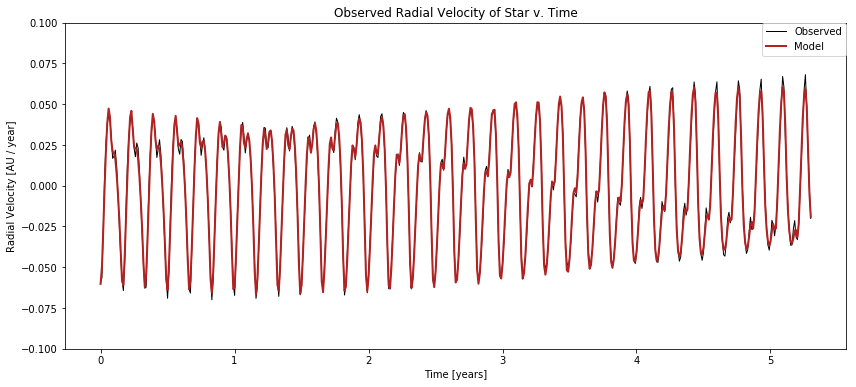

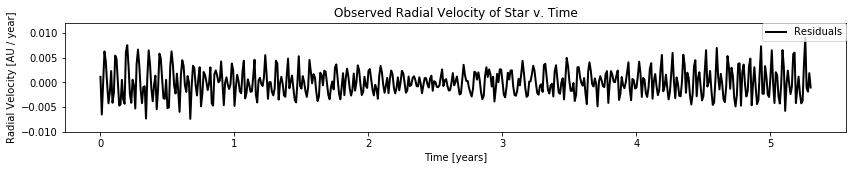

Initial parameters:
    GJ 786d: e = 0.2070, P = 0.0053, tp = 0.0000
    GJ 786c: e = 0.2559, P = 0.0824, tp = 0.0000
    GJ 786b: e = 0.0324, P = 0.1673, tp = 0.0000
    GJ 786e: e = 0.0550, P = 0.3402, tp = 0.0000

Optimized model:
    GJ 786d: e = 0.9544, P = 0.0054, tp = -0.0182
    GJ 786c: e = 0.0728, P = 0.0826, tp = -0.0058
    GJ 786b: e = 0.0296, P = 0.1671, tp = -0.0342
    GJ 786e: e = 0.3502, P = 0.3385, tp = 0.0427

Result:
    X^2 = 0.0038

Residuals:
    Average = -1.86e-11
    Standard Deviation = 2.69e-03


In [19]:
# Make a new model given the optimized parameters from scipy.optimize.minimize
minimized_vrad_model = make_vrad_model(result.x, times, vrad_observed)

# Plot the observed and modelled radial velocities
plt.figure(figsize=(14,6))

plt.plot(times, vrad_observed, color='black', label="Observed", linewidth = 1)
plt.plot(times, minimized_vrad_model, color='firebrick', label="Model", linewidth = 2)

plt.title('Observed Radial Velocity of Star v. Time')
plt.xlabel('Time [years]')
plt.ylabel('Radial Velocity [AU / year]')
plt.ylim(-0.1, 0.1)
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.show()

# Plot the residuals
plt.figure(figsize=(14,2))
residuals = vrad_observed-minimized_vrad_model
plt.plot(times, residuals, color='black', label="Residuals", linewidth = 2)

plt.title('Observed Radial Velocity of Star v. Time')
plt.xlabel('Time [years]')
plt.ylabel('Radial Velocity [AU / year]')
plt.ylim(-0.01, 0.012)
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})
plt.show()

# Print model results
print("Initial parameters:")
print((f"    GJ 786d: e = {initial_parameters[0]:0.4f}, P = {initial_parameters[1]:0.4f}, tp = {initial_parameters[2]:0.4f}"))
print((f"    GJ 786c: e = {initial_parameters[3]:0.4f}, P = {initial_parameters[4]:0.4f}, tp = {initial_parameters[5]:0.4f}"))
print((f"    GJ 786b: e = {initial_parameters[6]:0.4f}, P = {initial_parameters[7]:0.4f}, tp = {initial_parameters[8]:0.4f}"))
print((f"    GJ 786e: e = {initial_parameters[9]:0.4f}, P = {initial_parameters[10]:0.4f}, tp = {initial_parameters[11]:0.4f}"))

print("\nOptimized model:")
print((f"    GJ 786d: e = {result.x[0]:0.4f}, P = {result.x[1]:0.4f}, tp = {result.x[2]:0.4f}"))
print((f"    GJ 786c: e = {result.x[3]:0.4f}, P = {result.x[4]:0.4f}, tp = {result.x[5]:0.4f}"))
print((f"    GJ 786b: e = {result.x[6]:0.4f}, P = {result.x[7]:0.4f}, tp = {result.x[8]:0.4f}"))
print((f"    GJ 786e: e = {result.x[9]:0.4f}, P = {result.x[10]:0.4f}, tp = {result.x[11]:0.4f}"))

print("\nResult:")
print(f"    X^2 = {compute_chi2(vrad_observed, minimized_vrad_model):0.4f}")

print("\nResiduals:")
print(f"    Average = {np.mean(residuals):0.2e}")
print(f"    Standard Deviation = {np.std(residuals):0.2e}")

## Part 4: TTV

In [20]:
# Initialize simulation
sim = rebound.Simulation()

# Set units
sim.units = ('days', 'AU', 'Mjupiter')

# Initial values = [d,c,b,e]
massStar = 387.76
mass = [0.02149,0.7142,2.2756,0.04594]
a = [0.0208,0.12950,0.208317,0.3343]
ecc = [0.207,0.2559,0.0324,0.055]
period = [1.937780,30.0881,61.1166,124.26]
MA = [6.2,5.14,5.68,5.85] # radians

# add central star
sim.add(m = massStar)

# add planets b,c,d, and e
for i in np.arange(0,len(mass)):
    sim.add(m=mass[i],a=a[i],e=ecc[i],M=MA[i])

sim.move_to_com()

In [22]:
# Four years = (365*4)/30 days = 49 transits

N=200
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[3].y - p[0].y
    t_old = sim.t
    sim.integrate(sim.t+0.5) # Check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit.
    t_new = sim.t
    if y_old*(p[3].y-p[0].y)<0. and p[3].x-p[0].x>0.: # Sign changed (y_old*y<0), planet in front of star (x>0).
        while t_new-t_old>1e-7:
            if y_old*(p[3].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05) # Integrate 0.05 to be past the transit

In [23]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


48.61762908783912


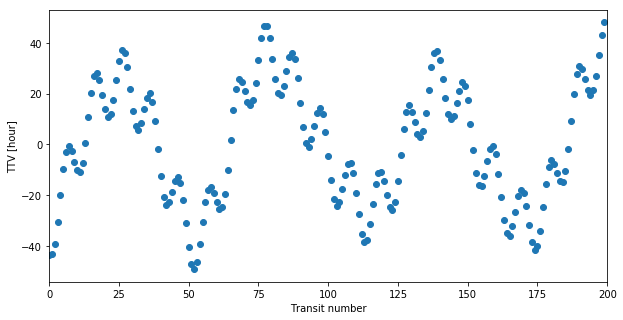

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hour]")
yVal = (transittimes-m*np.array(range(N))-c)*(365./2./np.pi)
plt.scatter(range(N), yVal)

amp = (np.max(yVal)-np.min(yVal))/2
print(amp)

Based on the above plot...
    
Amplitude: 41 hours
    
Period: 60 transits $\times$ 30.0881 days = 1,805 days

If we increase the mass of GJ876b to 4.55 M$_{Jup}$, the amplitude becomes 29 hours and the period becomes 30 transits $\times$ 30.0881 days = 903 days

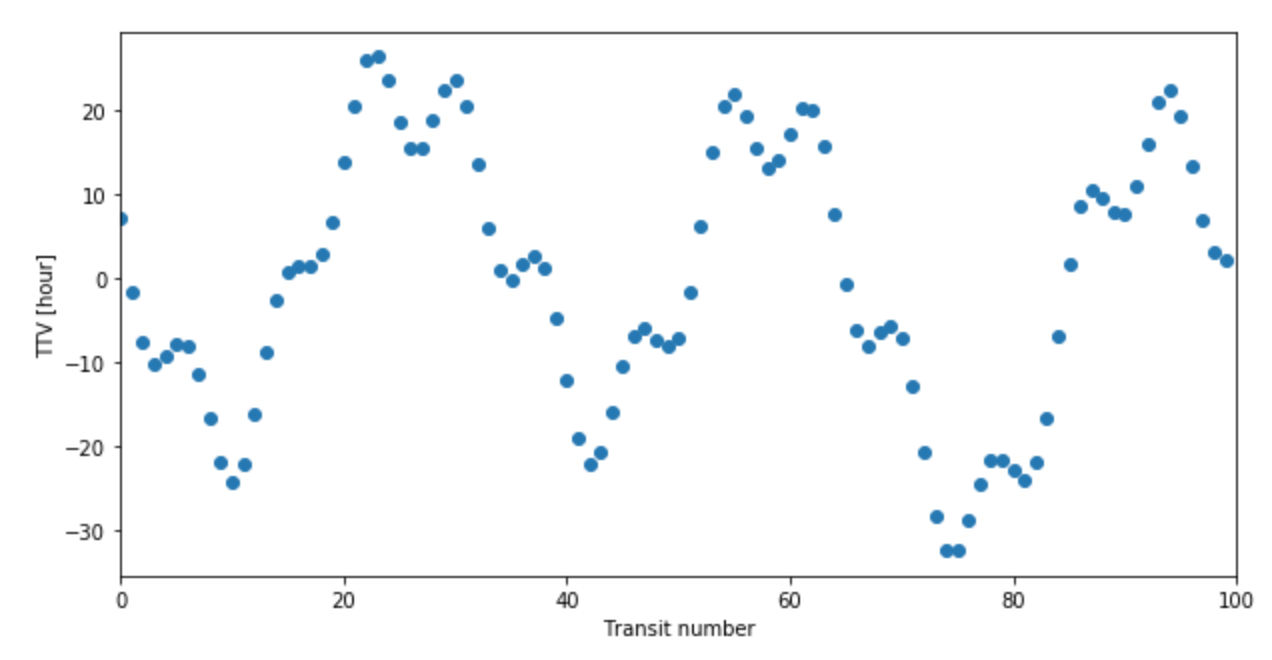

If we decrease the mass of GJ876b to 1.14 M$_{Jup}$, the amplitude becomes 75.4 hours and the period becomes 100 transits $\times$ 30.0881 days = 30,088 days

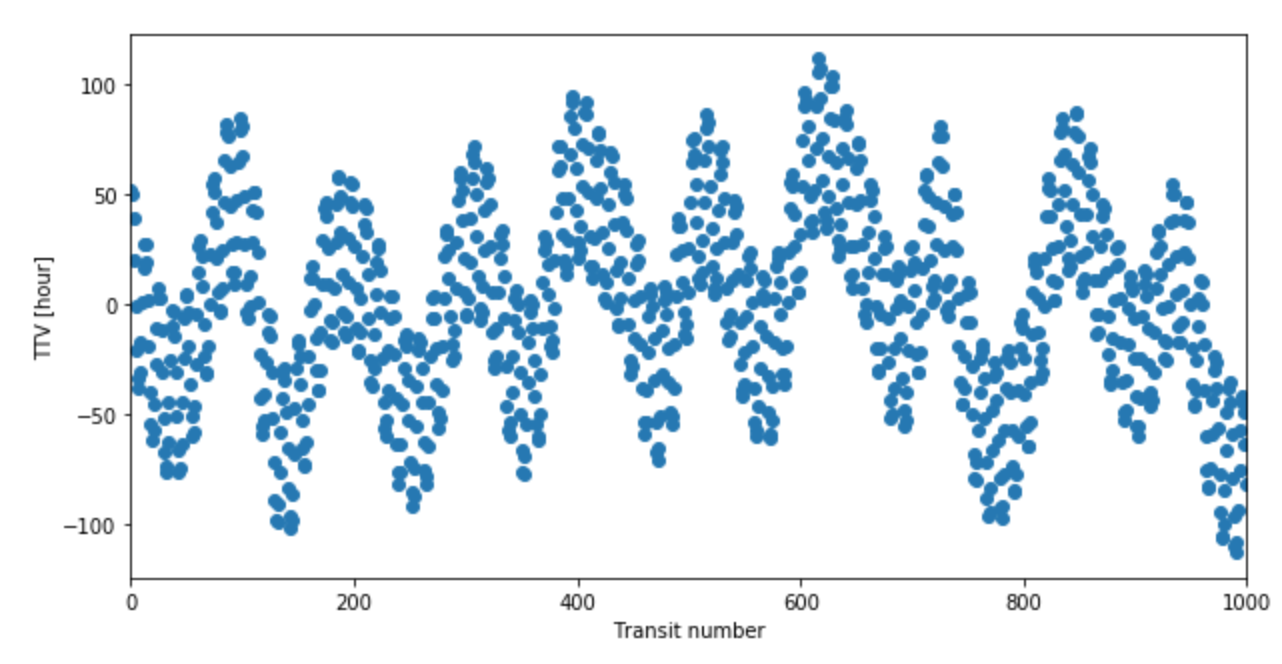